In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Cargar el dataset
file_path = 'dataset/vima.csv'
data = pd.read_csv(file_path, delimiter=';')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73221/1899765076.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, delimiter=';')


In [3]:
data.shape 

(226882, 30)

In [4]:

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73221/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [5]:
# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

In [6]:

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)


In [7]:
columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)


In [9]:

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [10]:

# Visualización inicial del dataset
print("Primeras filas del dataset:")
data.head()

Primeras filas del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,DIVISA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
0,2023,23,2,583,5,4,24,3,59985,1,...,5.0,6.0,2023.0,9.0,22.0,4.0,2023.0,2.0,5.0,6.0
1,2023,23,2,583,5,4,24,3,61209,1,...,5.0,6.0,2023.0,9.0,22.0,4.0,2023.0,2.0,5.0,6.0
2,2023,23,4,577,5,0,24,4,50973,1,...,5.0,6.0,2023.0,9.0,28.0,3.0,2023.0,3.0,5.0,6.0
3,2023,23,4,577,5,0,24,4,73734,1,...,5.0,6.0,2023.0,9.0,26.0,1.0,2023.0,3.0,5.0,6.0
4,2023,23,7,145,5,4,44,6,58283,1,...,5.0,6.0,2023.0,9.0,1.0,4.0,2023.0,3.0,5.0,6.0


In [11]:
# Análisis Exploratorio de Datos (EDA)
# Resumen estadístico
print("\nResumen estadístico del dataset:")
data.describe()


Resumen estadístico del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,DIVISA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
count,226882.000000,226882.000000,226882.000000,226882.00000,226882.000000,226882.000000,226882.000000,226882.000000,226882.000000,226882.000000,...,93332.000000,93332.000000,155069.000000,155069.000000,155069.000000,155069.000000,93233.000000,93233.000000,93233.000000,93233.000000
mean,2022.578323,14.737529,5.441917,1643.22290,6.369941,0.691571,25.751800,5.062460,43276.656601,0.399842,...,6.319205,3.049469,2022.630365,6.666400,17.544274,2.124635,2022.529062,6.295368,6.302683,3.055109
std,0.567672,2.577389,2.841615,978.03311,3.552226,1.184509,18.112642,2.194118,25101.013125,0.489867,...,3.547259,2.022674,0.562038,3.468826,8.770658,1.502301,1.212570,3.536371,3.553883,2.022311
min,2022.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2022.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000
25%,2022.000000,14.000000,4.000000,944.00000,3.000000,0.000000,9.000000,4.000000,21676.250000,0.000000,...,3.000000,1.000000,2022.000000,4.000000,10.000000,1.000000,2022.000000,3.000000,3.000000,1.000000
50%,2023.000000,14.000000,4.000000,1393.00000,6.000000,0.000000,30.000000,4.000000,43569.000000,0.000000,...,6.000000,3.000000,2023.000000,7.000000,19.000000,2.000000,2023.000000,6.000000,6.000000,3.000000
75%,2023.000000,14.000000,6.000000,2387.00000,9.000000,2.000000,43.000000,4.000000,65396.000000,1.000000,...,9.000000,5.000000,2023.000000,10.000000,25.000000,4.000000,2023.000000,9.000000,9.000000,5.000000
max,2024.000000,26.000000,18.000000,4032.00000,12.000000,4.000000,78.000000,14.000000,85997.000000,1.000000,...,12.000000,6.000000,2024.000000,12.000000,31.000000,6.000000,2024.000000,12.000000,12.000000,6.000000


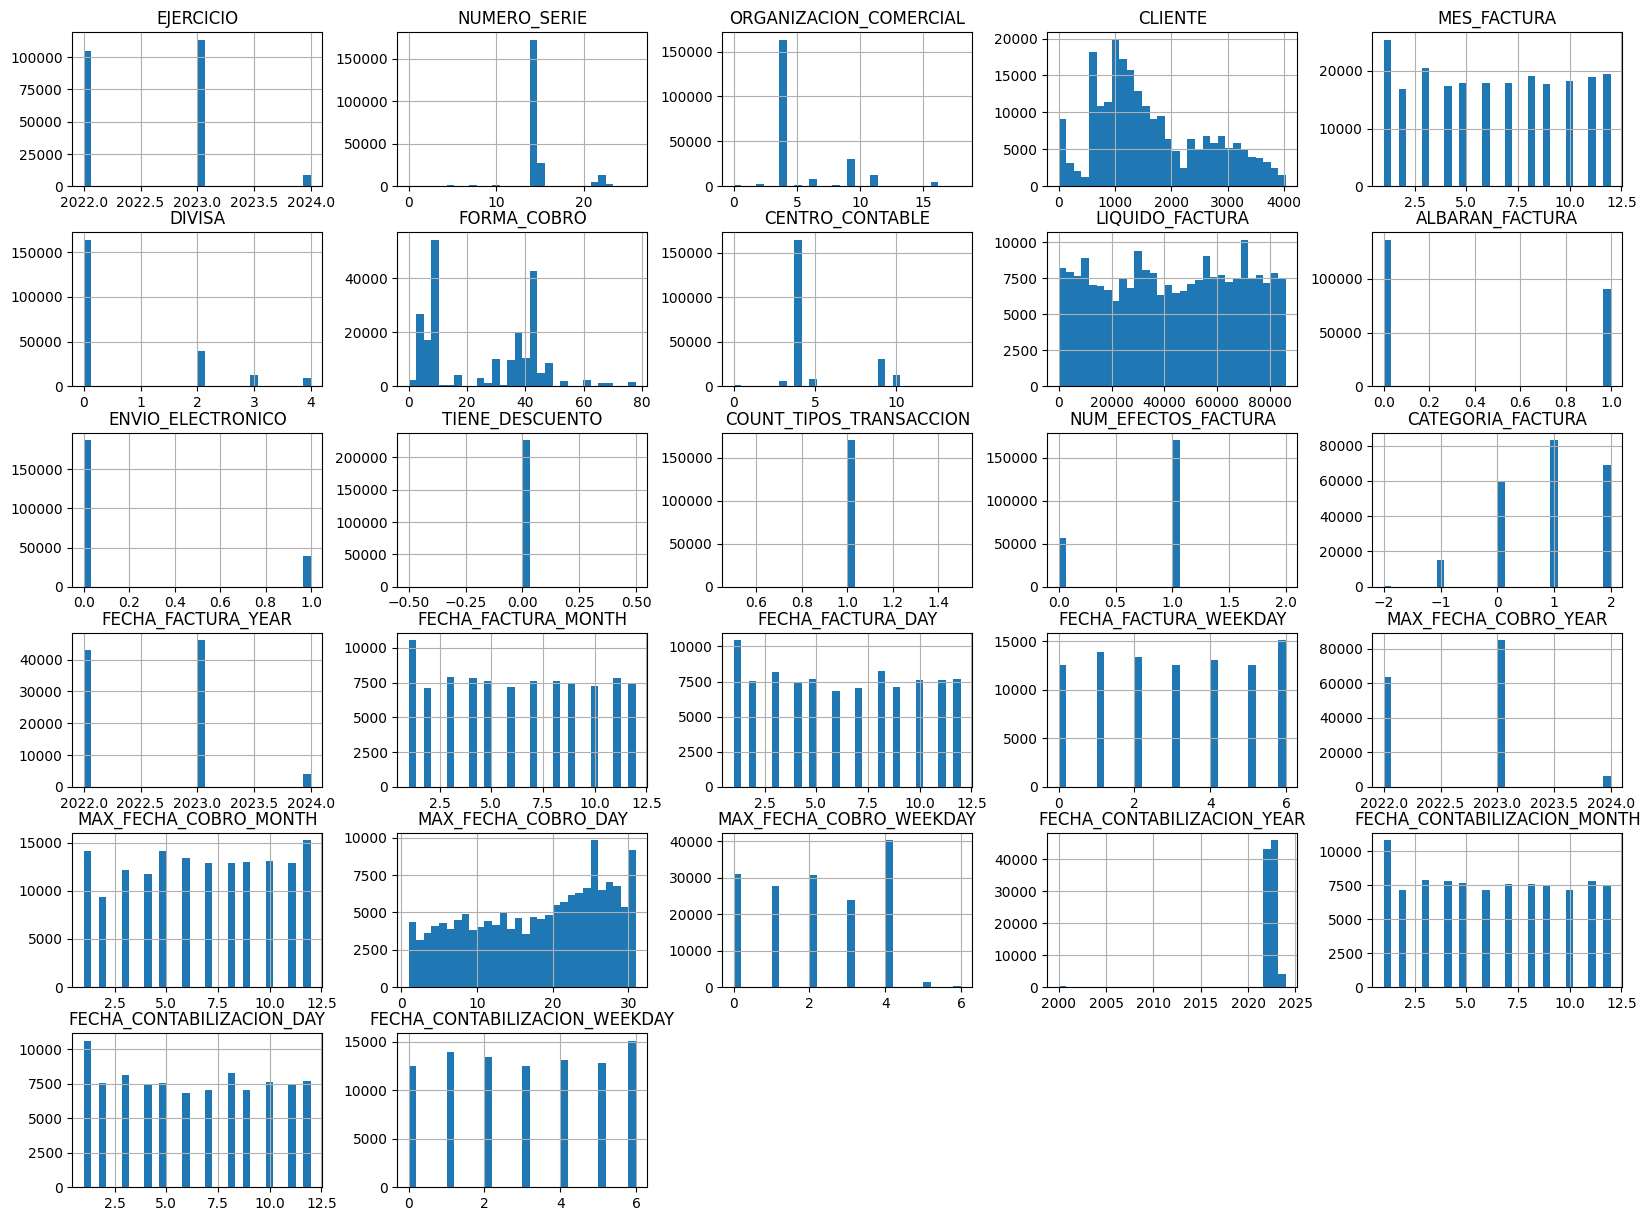

In [12]:

# Distribuciones de las características
data.hist(bins=30, figsize=(20, 15))
plt.show()


In [13]:

# Análisis de valores nulos
print("\nValores nulos en el dataset:")
data.isnull().sum()



Valores nulos en el dataset:


EJERCICIO                             0
NUMERO_SERIE                          0
ORGANIZACION_COMERCIAL                0
CLIENTE                               0
MES_FACTURA                           0
DIVISA                                0
FORMA_COBRO                           0
CENTRO_CONTABLE                       0
LIQUIDO_FACTURA                       0
ALBARAN_FACTURA                       0
ENVIO_ELECTRONICO                     0
TIENE_DESCUENTO                       0
COUNT_TIPOS_TRANSACCION           56317
NUM_EFECTOS_FACTURA                   0
CATEGORIA_FACTURA                     0
FECHA_FACTURA_YEAR               133550
FECHA_FACTURA_MONTH              133550
FECHA_FACTURA_DAY                133550
FECHA_FACTURA_WEEKDAY            133550
MAX_FECHA_COBRO_YEAR              71813
MAX_FECHA_COBRO_MONTH             71813
MAX_FECHA_COBRO_DAY               71813
MAX_FECHA_COBRO_WEEKDAY           71813
FECHA_CONTABILIZACION_YEAR       133649
FECHA_CONTABILIZACION_MONTH      133649


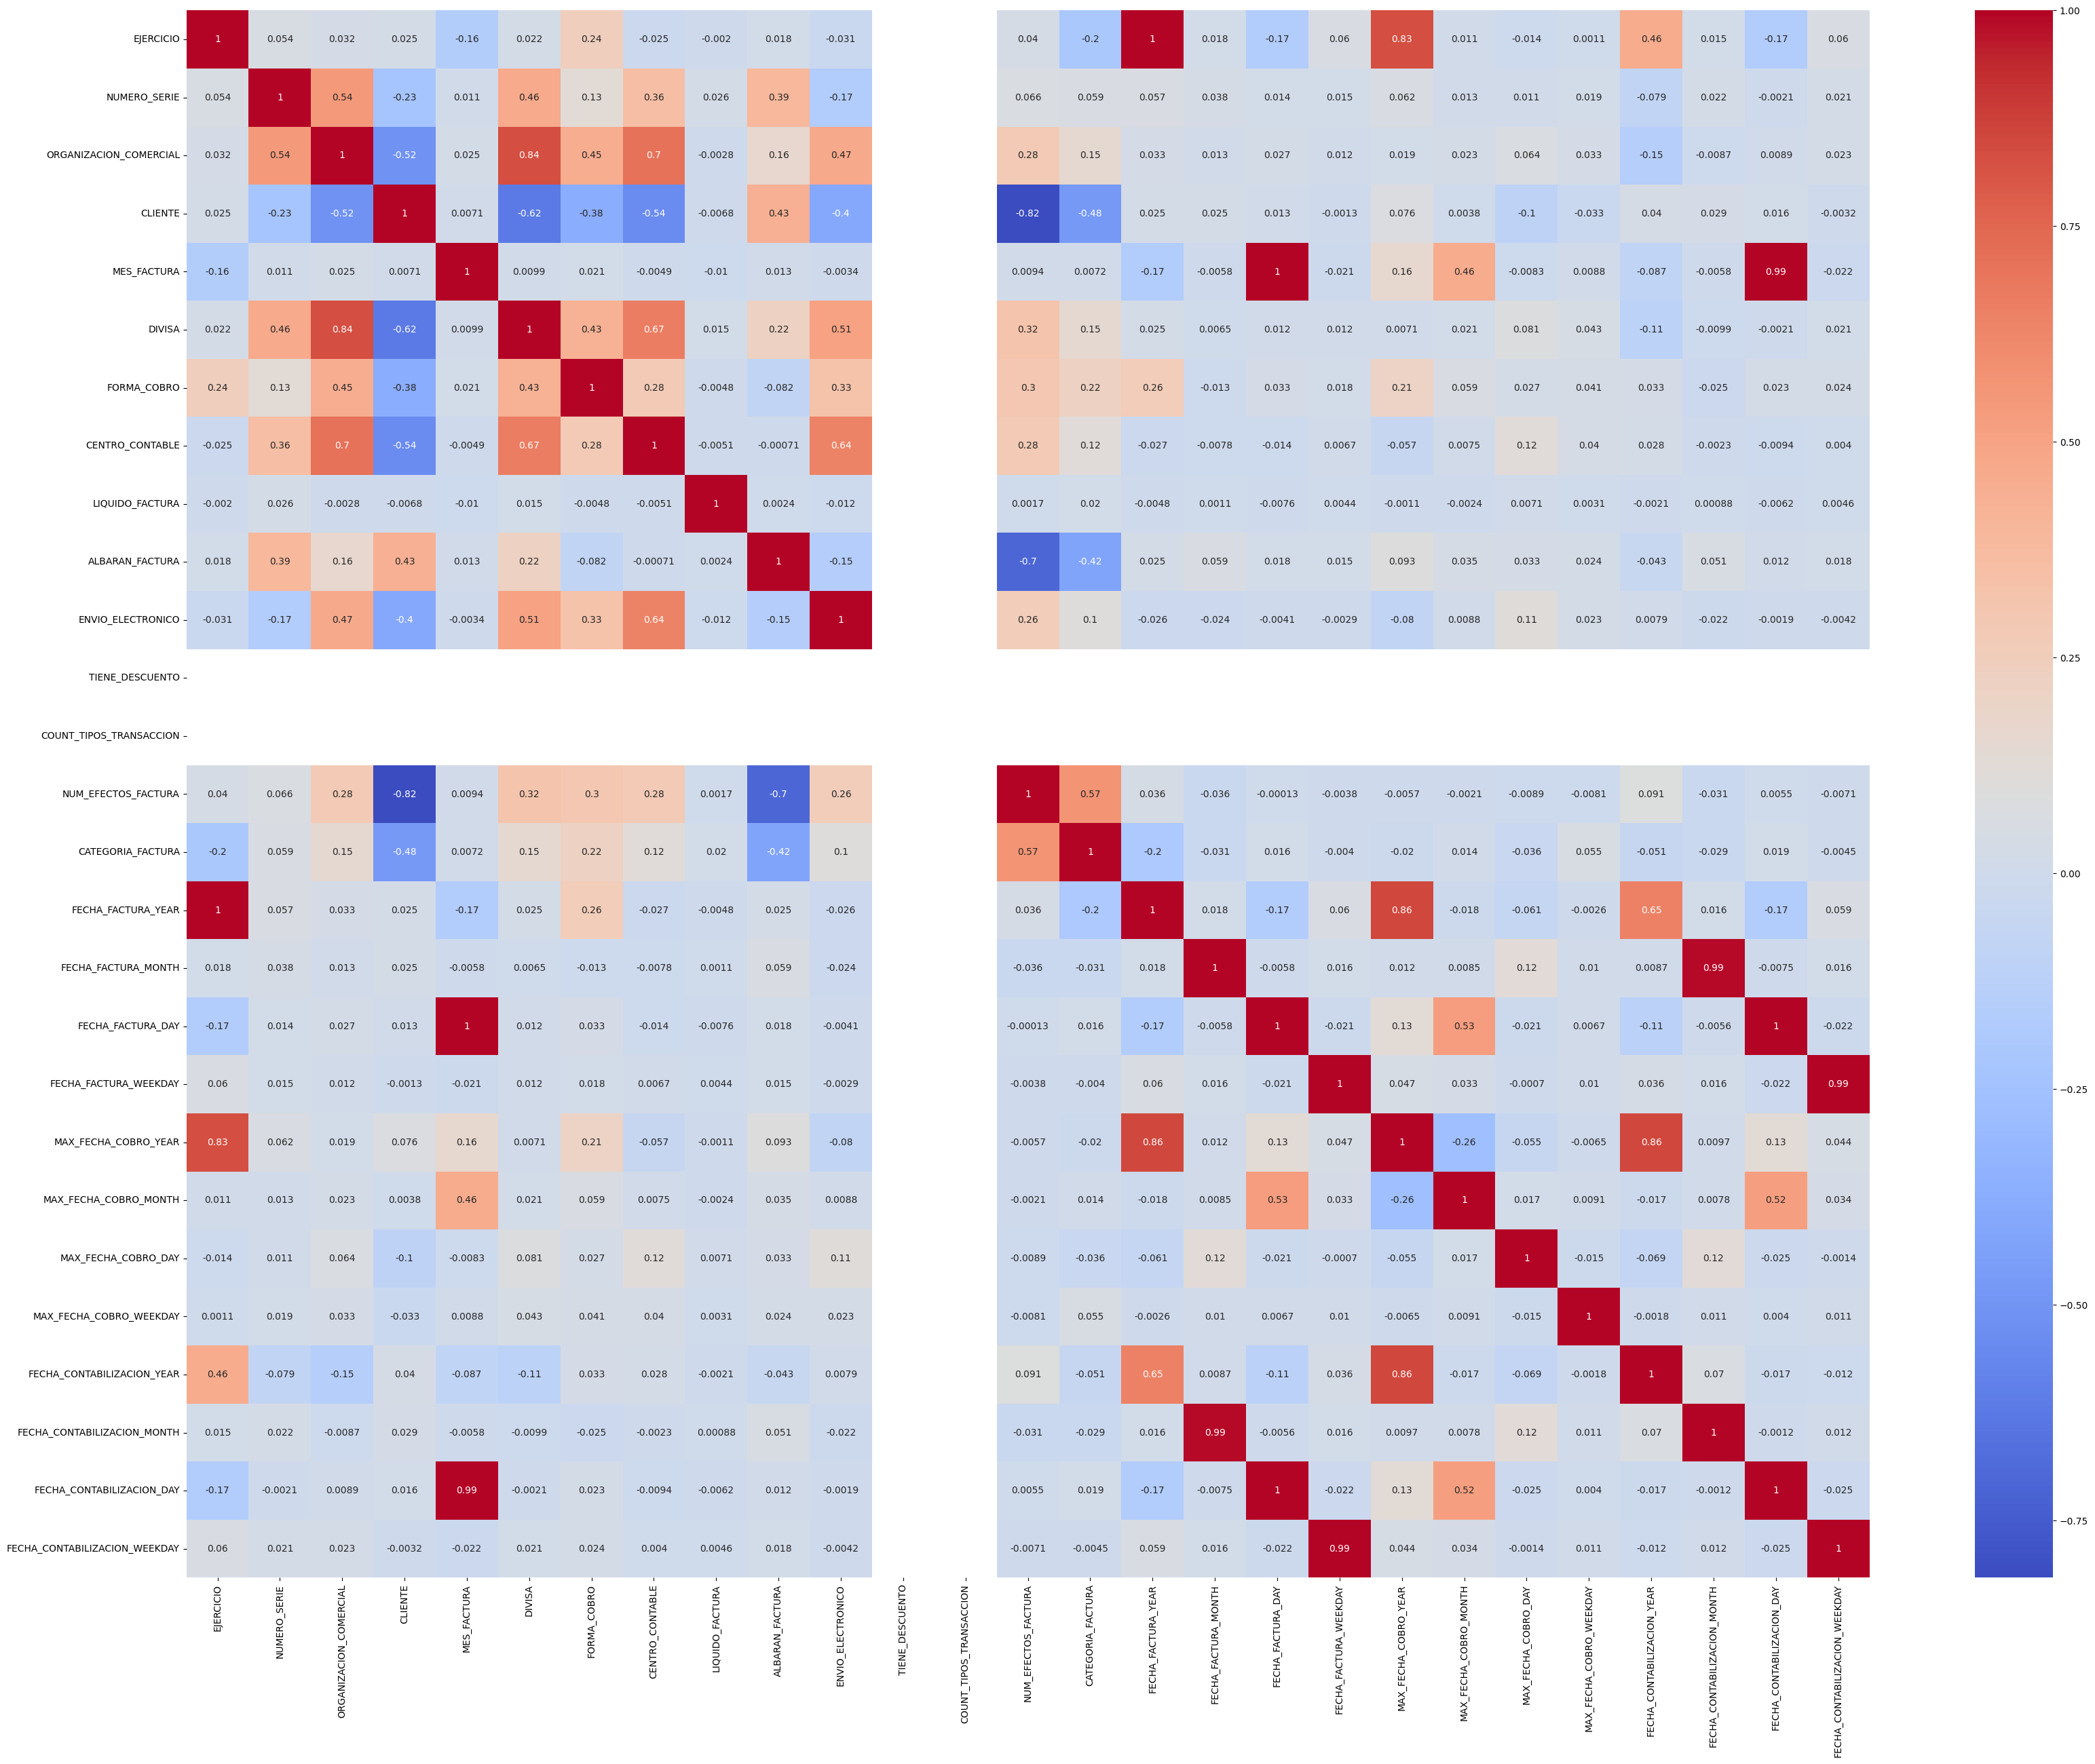

In [14]:
# Correlaciones entre las características
plt.figure(figsize=(40, 30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:

# Manejo de valores nulos
data.fillna(data.mean(), inplace=True)


In [16]:

# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)
#y = data['CATEGORIA_FACTURA']
# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])


In [17]:

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:

# Entrenamiento y Validación de Modelos de Clasificación

# Árboles de Decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nÁrboles de Decisión:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))



Árboles de Decisión:
              precision    recall  f1-score   support

           0       0.38      0.52      0.44        31
           1       0.99      1.00      0.99      3060
           2       0.97      0.97      0.97     11907
           3       0.87      0.88      0.88     16334
           4       0.88      0.87      0.88     14045

    accuracy                           0.91     45377
   macro avg       0.82      0.85      0.83     45377
weighted avg       0.91      0.91      0.91     45377

[[   16     0     0    13     2]
 [    0  3045     1     2    12]
 [    1     0 11549   319    38]
 [   24    11   336 14340  1623]
 [    1     7    32  1755 12250]]


In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, criterion='entropy', max_features='log2')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.39      0.53        31
           1       1.00      1.00      1.00      3060
           2       0.99      0.97      0.98     11907
           3       0.87      0.91      0.89     16334
           4       0.90      0.87      0.88     14045

    accuracy                           0.92     45377
   macro avg       0.92      0.83      0.86     45377
weighted avg       0.92      0.92      0.92     45377

[[   12     0     0    18     1]
 [    0  3052     0     0     8]
 [    0     0 11507   378    22]
 [    2     8    64 14863  1397]
 [    0     0     8  1860 12177]]


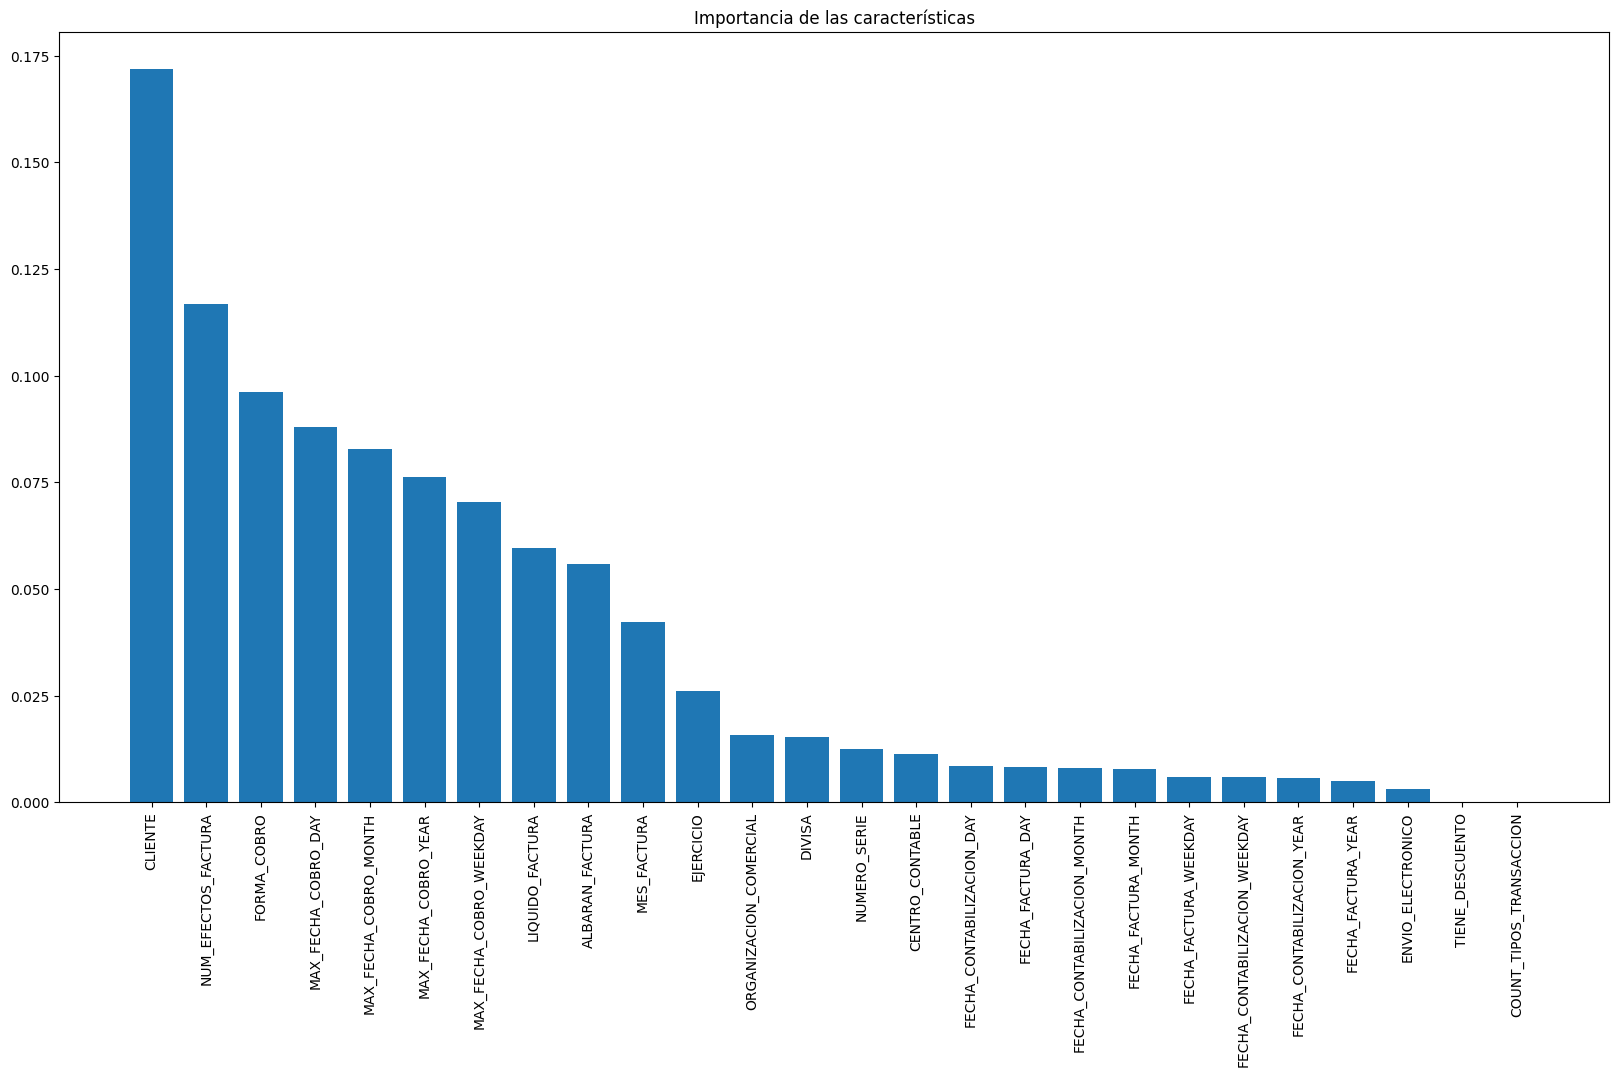

In [21]:
#revisamos la importancia de cada feature
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(20, 10))
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [22]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

# evaluamos el sobreajuste
y_pred_train_rf = rf.predict(X_train)
print("Accuracy Train: ", accuracy_score(y_train, y_pred_train_rf))


Accuracy:  0.9170064129404765
Accuracy Train:  0.998876064020275


In [23]:
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.99      0.99      0.99      3060
           2       1.00      0.96      0.98     11907
           3       0.74      0.76      0.75     16334
           4       0.71      0.72      0.71     14045

    accuracy                           0.81     45377
   macro avg       0.69      0.68      0.69     45377
weighted avg       0.81      0.81      0.81     45377

[[    0     0     0    28     3]
 [    0  3019     0    38     3]
 [    0     0 11398   370   139]
 [    0    33    29 12365  3907]
 [    0     0     1  3992 10052]]


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [24]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))

Accuracy:  0.8117328161844106


In [25]:
# XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.35      0.50        31
           1       1.00      1.00      1.00      3060
           2       1.00      0.97      0.98     11907
           3       0.89      0.93      0.91     16334
           4       0.92      0.90      0.91     14045

    accuracy                           0.93     45377
   macro avg       0.93      0.83      0.86     45377
weighted avg       0.93      0.93      0.93     45377

[[   11     0     0    20     0]
 [    0  3052     0     1     7]
 [    0     0 11510   383    14]
 [    2     7    22 15157  1146]
 [    0     0     6  1416 12623]]
